# Install Modules

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install imblearn
!pip install xgboost
!pip install tensorflow

# Import Dependencies

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import seaborn as sns
import sklearn
import imblearn
import matplotlib.pyplot as plt
import time
import os
import sklearn.metrics as m
import xgboost as xgbxgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.client import device_lib
import logging
import warnings

# Setup Stuff

In [2]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [3]:
get_available_gpus()

[]

In [4]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
logging.getLogger("tensorflow").setLevel(logging.WARNING)
#Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')


# Prepare the Dataset File

### Join the Dataset parts

In [ ]:
def prepare_base_dataset_file(__data_folder, __force_overwrite = False):
    """
    This function prepares the dataset file for the training and testing of the models.
    """

    # the dataset folder
    _data_csv_folder = os.path.join(__data_folder, 'MachineLearningCSV', 'MachineLearningCVE')

    # the list of files to be joined
    _data_files = []
    _data_files.append(os.path.join(_data_csv_folder, 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'))
    _data_files.append(os.path.join(_data_csv_folder, 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv'))
    _data_files.append(os.path.join(_data_csv_folder, 'Friday-WorkingHours-Morning.pcap_ISCX.csv'))
    _data_files.append(os.path.join(_data_csv_folder, 'Monday-WorkingHours.pcap_ISCX.csv'))
    _data_files.append(os.path.join(_data_csv_folder, 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv'))
    _data_files.append(os.path.join(_data_csv_folder, 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv'))
    _data_files.append(os.path.join(_data_csv_folder, 'Tuesday-WorkingHours.pcap_ISCX.csv'))
    _data_files.append(os.path.join(_data_csv_folder, 'Wednesday-workingHours.pcap_ISCX.csv'))

    # the final dataset file
    _final_dataset_path = os.path.join(__data_folder, "dataset_base.csv")

    # check if the dataset folder exists
    if not os.path.exists(_data_csv_folder):
        print('Data folder not found')
        return False

    # check if the dataset files exist
    if os.path.exists(_final_dataset_path) and not __force_overwrite:
        print('Joined dataset already exists')
        return False

    # load and join the dataset files
    _temp = None
    _data = pd.read_csv(_data_files[0])
    print(f'Loaded {_data_files[0]}')
    for file in _data_files[1:]:
        _temp = pd.read_csv(file)
        _data = pd.concat([_data, _temp])
        print(f'Loaded {file}')
    del _temp

    # preprocess the dataset
    print("Preprocessing the dataset ...", end = ' ')
    _data[['Flow Bytes/s', ' Flow Packets/s']] = _data[['Flow Bytes/s', ' Flow Packets/s']].apply(pd.to_numeric)
    print("Done")

    # drop the useless stuff
    print("Dropping useless columns ...", end = ' ')
    _data.drop([' Bwd PSH Flags'], axis=1, inplace=True)
    _data.drop([' Bwd URG Flags'], axis=1, inplace=True)
    _data.drop(['Fwd Avg Bytes/Bulk'], axis=1, inplace=True)
    _data.drop([' Fwd Avg Packets/Bulk'], axis=1, inplace=True)
    _data.drop([' Fwd Avg Bulk Rate'], axis=1, inplace=True)
    _data.drop([' Bwd Avg Bytes/Bulk'], axis=1, inplace=True)
    _data.drop([' Bwd Avg Packets/Bulk'], axis=1, inplace=True)
    _data.drop(['Bwd Avg Bulk Rate'], axis=1, inplace=True)
    print("Done")

    # drop the rows with NaN, inf, -inf values
    print("Dropping rows with NaN, inf, -inf values ...", end = ' ')
    _data.replace([np.inf, -np.inf], np.nan, inplace=True)
    _data.dropna(axis="index", how="any", inplace=True)
    print("Done")

    # write the final dataset to file
    print("Writing Joined Dataset to file ...", end = ' ')
    _data.to_csv(_final_dataset_path, index=False)
    print("Done")

    # delete the temporary variables
    del _data

    return True

In [ ]:
prepare_base_dataset_file('dataset', True)

Loaded dataset\MachineLearningCSV\MachineLearningCVE\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Loaded dataset\MachineLearningCSV\MachineLearningCVE\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Loaded dataset\MachineLearningCSV\MachineLearningCVE\Friday-WorkingHours-Morning.pcap_ISCX.csv
Loaded dataset\MachineLearningCSV\MachineLearningCVE\Monday-WorkingHours.pcap_ISCX.csv
Loaded dataset\MachineLearningCSV\MachineLearningCVE\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Loaded dataset\MachineLearningCSV\MachineLearningCVE\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Loaded dataset\MachineLearningCSV\MachineLearningCVE\Tuesday-WorkingHours.pcap_ISCX.csv
Loaded dataset\MachineLearningCSV\MachineLearningCVE\Wednesday-workingHours.pcap_ISCX.csv
Preprocessing the dataset ... Done
Dropping useless columns ... Done
Dropping rows with NaN, inf, -inf values ... Done
Writing Joined Dataset to file ... Done


True

### Preprocess the Dataset

In [5]:
def load_and_preprocess_base_dataset(__data_folder, __force_overwrite = False):
    _source_dataset_path = os.path.join(__data_folder, "dataset_base.csv")
    _final_dataset_path = os.path.join(__data_folder, "dataset_preprocessed.csv")

    # check if the dataset exists
    if not os.path.exists(_source_dataset_path):
        print('Base Dataset not found')
        return False

    # check if the dataset files exist
    if os.path.exists(_final_dataset_path) and not __force_overwrite:
        print('Preprocessed dataset already exists')
        return False
    
    # load the dataset
    print("Loading the base dataset ...", end = ' ')
    _data = pd.read_csv(_source_dataset_path)
    print("Done")

    _scalar = StandardScaler()
    _minMaxScalar = MinMaxScaler()
    _cols = _data.select_dtypes(include=['float64', 'int64']).columns

    # preprocess the dataset
    print("Preprocessing the dataset ...", end = ' ')
    _fit_data = _scalar.fit_transform(_data.select_dtypes(include=['float64', 'int64']))
    _fit_data = _minMaxScalar.fit_transform(_fit_data)
    print("Done")

    
    # create the final dataset
    print("Creating the final dataset ...", end = ' ')
    _data_preprocessed = pd.DataFrame(_fit_data, columns=_cols)
    _data_preprocessed[' Label'] = _data[' Label']
    print("Done")

    # write the final dataset to file
    print("Writing Preprocessed Dataset to file ...", end = ' ')
    _data_preprocessed.to_csv(_final_dataset_path, index=False)
    print("Done")

    del _data
    del _fit_data
    del _data_preprocessed

    return True

In [6]:
load_and_preprocess_base_dataset('dataset', True)

Loading the base dataset ... Done
Preprocessing the dataset ... Done
Creating the final dataset ... Done
Writing Preprocessed Dataset to file ... Done


True

### Use SMOTE to balance the Dataset

In [7]:
dataset = pd.read_csv('dataset/dataset_preprocessed.csv')

In [8]:
dataset.value_counts(' Label')

 Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

Here we drop the biggest class BENIGN

In [9]:
dataset.drop(dataset[dataset[' Label'] == 'BENIGN'].index, inplace=True)

In [10]:
dataset.value_counts(' Label')

 Label
DoS Hulk                      230124
PortScan                      158804
DDoS                          128025
DoS GoldenEye                  10293
FTP-Patator                     7935
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1956
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

In [11]:
smote_sampler = SMOTE(random_state=42)

In [12]:
X = dataset.drop([' Label'], axis=1)
y = dataset[' Label']

In [13]:
X, y = smote_sampler.fit_resample(X.to_numpy(), y.to_numpy())

In [14]:
X_cols = dataset.drop([' Label'], axis=1).columns
y_cols = [' Label']
X = pd.DataFrame(X, columns=X_cols)
y = pd.DataFrame(y, columns=y_cols)

In [15]:
new_dataset = pd.concat([X, y], axis=1)

Reload the original dataset to merge with generated one

In [16]:
dataset = pd.read_csv('dataset/dataset_preprocessed.csv')

In [17]:
dataset = pd.concat([dataset, new_dataset])

In [18]:
dataset.value_counts(' Label')

 Label
BENIGN                        2271320
DoS Hulk                       460248
PortScan                       388928
DDoS                           358149
DoS GoldenEye                  240417
FTP-Patator                    238059
SSH-Patator                    236021
DoS slowloris                  235920
DoS Slowhttptest               235623
Bot                            232080
Web Attack � Brute Force       231631
Web Attack � XSS               230776
Infiltration                   230160
Web Attack � Sql Injection     230145
Heartbleed                     230135
Name: count, dtype: int64

In [19]:
dataset.to_csv('dataset/dataset_preprocessed_smote.csv', index=False)

Cleanup and Free Memory

In [20]:
del dataset
del X
del y
del smote_sampler
del new_dataset

# Prepare the cAAEE Model

In [47]:
aaee_generated_data = pd.read_csv('dataset/aaee_generated.csv')

In [48]:
aaee_generated_data.value_counts(' Label')

 Label
Bot                           230124
DDoS                          230124
DoS GoldenEye                 230124
DoS Hulk                      230124
DoS Slowhttptest              230124
DoS slowloris                 230124
FTP-Patator                   230124
Heartbleed                    230124
Infiltration                  230124
PortScan                      230124
SSH-Patator                   230124
Web Attack � Brute Force      230124
Web Attack � Sql Injection    230124
Web Attack � XSS              230124
Name: count, dtype: int64

In [49]:
aaee_generated_data.head()

Destination Port   Flow Duration   Total Fwd Packets  \
0          -1.090784       -4.346685           -8.245029   
1          -1.659598       -7.707456          -11.889160   
2          -1.299653       -6.930700          -11.307231   
3          -2.527102       -4.824354          -10.872876   
4           0.251779       -9.791618           -9.985571   

    Total Backward Packets  Total Length of Fwd Packets  \
0                -8.699533                    -5.001663   
1               -12.245406                   -12.005301   
2               -10.871269                   -12.413628   
3               -10.782633                    -9.801720   
4               -11.055852                    -8.856457   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                    -10.904705               -0.128883   
1                    -15.239332               -7.688538   
2                    -14.116439               -7.989937   
3                    -13.999286               -4.599152   
4                    -13.251135               -4.873038   

    Fwd Packet Length Min   Fwd Packet Length Mean   Fwd Packet Length Std  \
0              -12.579715                -0.307916               -0.465514   
1               -7.941646                -7.124451               -6.641447   
2               -6.033175                -7.225377               -7.241423   
3               -9.839927                -4.533030               -4.488209   
4               -6.629494                -3.756270               -4.486139   

   Bwd Packet Length Max   Bwd Packet Length Min   Bwd Packet Length Mean  \
0              -2.862216               -5.871634                -2.758916   
1              -8.244658               -6.962738                -7.308014   
2              -7.303515               -6.345926                -7.023419   
3              -4.884774               -6.470424                -4.924552   
4              -9.116898               -6.956256                -7.673738   

    Bwd Packet Length Std  Flow Bytes/s   Flow Packets/s   Flow IAT Mean  \
0               -3.204328     -2.103019        -0.641543       -6.535144   
1               -8.565076     -2.065826        -0.742923       -9.403538   
2               -7.800232     -2.091673        -0.560299       -9.125073   
3               -4.737417     -2.040007        -0.664820       -6.945097   
4               -9.811379     -2.031567        -0.474563      -10.477650   

    Flow IAT Std   Flow IAT Max   Flow IAT Min  Fwd IAT Total   Fwd IAT Mean  \
0      -5.646882      -5.491242     -24.577960      -4.468714      -5.912508   
1      -8.384009      -8.040185     -15.393041      -7.872322      -8.625756   
2      -7.862981      -7.372334     -13.037400      -6.955302      -8.337544   
3      -5.842922      -5.487146     -19.830230      -4.924123      -5.978970   
4      -9.817017     -10.359337     -14.224205     -10.150842     -10.452786   

    Fwd IAT Std   Fwd IAT Max   Fwd IAT Min  Bwd IAT Total   Bwd IAT Mean  \
0     -6.613748     -5.690137     -8.501327      -3.640905      -5.311135   
1     -9.221052     -8.268017     -8.190412      -6.997830      -7.546408   
2     -8.786196     -7.466053     -7.452258      -5.161275      -6.880338   
3     -7.339962     -5.563602     -6.431760      -4.792812      -5.920642   
4    -10.033244    -10.928205    -10.379566     -10.814219     -10.525833   

    Bwd IAT Std   Bwd IAT Max   Bwd IAT Min  Fwd PSH Flags   Fwd URG Flags  \
0     -5.596641     -4.946742     -6.615354     -35.626633      -20.170868   
1     -8.337973     -7.129168     -8.255496     -15.851090      -16.096987   
2     -7.348248     -5.229919     -9.472125     -10.483886      -15.916084   
3     -7.632258     -5.618819     -6.357026     -23.437895      -17.342213   
4     -9.631356    -11.144358    -12.323654     -17.930641      -17.386700   

    Fwd Header Length   Bwd Header Length  Fwd Packets/s   Bwd Packets/s  \
0            8.278336            5.187221     -12.79317

In [50]:
original_data = pd.read_csv('dataset/dataset_preprocessed.csv')

In [51]:
original_data.value_counts(' Label')

 Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [52]:
original_data.head()

Destination Port   Flow Duration   Total Fwd Packets  \
0           0.837186    1.333333e-07            0.000005   
1           0.840070    1.016667e-06            0.000000   
2           0.840085    5.416666e-07            0.000000   
3           0.705516    3.916666e-07            0.000000   
4           0.837156    1.333333e-07            0.000005   

    Total Backward Packets  Total Length of Fwd Packets  \
0                 0.000000                 9.302326e-07   
1                 0.000003                 4.651163e-07   
2                 0.000003                 4.651163e-07   
3                 0.000003                 4.651163e-07   
4                 0.000000                 9.302326e-07   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                  0.000000e+00                0.000242   
1                  9.153974e-09                0.000242   
2                  9.153974e-09                0.000242   
3                  9.153974e-09                0.000242   
4                  0.000000e+00                0.000242   

    Fwd Packet Length Min   Fwd Packet Length Mean   Fwd Packet Length Std  \
0                0.002581                  0.00101                     0.0   
1                0.002581                  0.00101                     0.0   
2                0.002581                  0.00101                     0.0   
3                0.002581                  0.00101                     0.0   
4                0.002581                  0.00101                     0.0   

   Bwd Packet Length Max   Bwd Packet Length Min   Bwd Packet Length Mean  \
0               0.000000                0.000000                 0.000000   
1               0.000307                0.002072                 0.001034   
2               0.000307                0.002072                 0.001034   
3               0.000307                0.002072                 0.001034   
4               0.000000                0.000000                 0.000000   

    Bwd Packet Length Std  Flow Bytes/s   Flow Packets/s   Flow IAT Mean  \
0                     0.0      0.113636         0.444444    1.333333e-07   
1                     0.0      0.111968         0.336391    1.016667e-06   
2                     0.0      0.112020         0.339744    5.416666e-07   
3                     0.0      0.112072         0.343137    3.916666e-07   
4                     0.0      0.113636         0.444444    1.333333e-07   

    Flow IAT Std   Flow IAT Max   Flow IAT Min  Fwd IAT Total   Fwd IAT Mean  \
0            0.0   1.333333e-07   1.416667e-07   2.500000e-08   2.500000e-08   
1            0.0   1.016667e-06   1.025000e-06   0.000000e+00   0.000000e+00   
2            0.0   5.416666e-07   5.499999e-07   0.000000e+00   0.000000e+00   
3            0.0   3.916666e-07   4.000000e-07   0.000000e+00   0.000000e+00   
4            0.0   1.333333e-07   1.416667e-07   2.500000e-08   2.500000e-08   

    Fwd IAT Std   Fwd IAT Max   Fwd IAT Min  Bwd IAT Total   Bwd IAT Mean  \
0           0.0  2.500000e-08  1.250000e-07            0.0            0.0   
1           0.0  0.000000e+00  9.999999e-08            0.0            0.0   
2           0.0  0.000000e+00  9.999999e-08            0.0            0.0   
3           0.0  0.000000e+00  9.999999e-08            0.0            0.0   
4           0.0  2.500000e-08  1.250000e-07            0.0            0.0   

    Bwd IAT Std   Bwd IAT Max   Bwd IAT Min  Fwd PSH Flags   Fwd URG Flags  \
0           0.0           0.0           0.0            0.0             0.0   
1           0.0           0.0           0.0            0.0             0.0   
2           0.0           0.0           0.0            0.0             0.0   
3           0.0           0.0           0.0            0.0             0.0   
4           0.0           0.0           0.0            0.0             0.0   

    Fwd Header Length   Bwd Header Length  Fwd Packets/s   Bwd Packets/s  \
0            0.999856            0.994592       0.22222

In [53]:
merged_data = pd.concat([original_data, aaee_generated_data])

In [54]:
merged_data.head()

Destination Port   Flow Duration   Total Fwd Packets  \
0           0.837186    1.333333e-07            0.000005   
1           0.840070    1.016667e-06            0.000000   
2           0.840085    5.416666e-07            0.000000   
3           0.705516    3.916666e-07            0.000000   
4           0.837156    1.333333e-07            0.000005   

    Total Backward Packets  Total Length of Fwd Packets  \
0                 0.000000                 9.302326e-07   
1                 0.000003                 4.651163e-07   
2                 0.000003                 4.651163e-07   
3                 0.000003                 4.651163e-07   
4                 0.000000                 9.302326e-07   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                  0.000000e+00                0.000242   
1                  9.153974e-09                0.000242   
2                  9.153974e-09                0.000242   
3                  9.153974e-09                0.000242   
4                  0.000000e+00                0.000242   

    Fwd Packet Length Min   Fwd Packet Length Mean   Fwd Packet Length Std  \
0                0.002581                  0.00101                     0.0   
1                0.002581                  0.00101                     0.0   
2                0.002581                  0.00101                     0.0   
3                0.002581                  0.00101                     0.0   
4                0.002581                  0.00101                     0.0   

   Bwd Packet Length Max   Bwd Packet Length Min   Bwd Packet Length Mean  \
0               0.000000                0.000000                 0.000000   
1               0.000307                0.002072                 0.001034   
2               0.000307                0.002072                 0.001034   
3               0.000307                0.002072                 0.001034   
4               0.000000                0.000000                 0.000000   

    Bwd Packet Length Std  Flow Bytes/s   Flow Packets/s   Flow IAT Mean  \
0                     0.0      0.113636         0.444444    1.333333e-07   
1                     0.0      0.111968         0.336391    1.016667e-06   
2                     0.0      0.112020         0.339744    5.416666e-07   
3                     0.0      0.112072         0.343137    3.916666e-07   
4                     0.0      0.113636         0.444444    1.333333e-07   

    Flow IAT Std   Flow IAT Max   Flow IAT Min  Fwd IAT Total   Fwd IAT Mean  \
0            0.0   1.333333e-07   1.416667e-07   2.500000e-08   2.500000e-08   
1            0.0   1.016667e-06   1.025000e-06   0.000000e+00   0.000000e+00   
2            0.0   5.416666e-07   5.499999e-07   0.000000e+00   0.000000e+00   
3            0.0   3.916666e-07   4.000000e-07   0.000000e+00   0.000000e+00   
4            0.0   1.333333e-07   1.416667e-07   2.500000e-08   2.500000e-08   

    Fwd IAT Std   Fwd IAT Max   Fwd IAT Min  Bwd IAT Total   Bwd IAT Mean  \
0           0.0  2.500000e-08  1.250000e-07            0.0            0.0   
1           0.0  0.000000e+00  9.999999e-08            0.0            0.0   
2           0.0  0.000000e+00  9.999999e-08            0.0            0.0   
3           0.0  0.000000e+00  9.999999e-08            0.0            0.0   
4           0.0  2.500000e-08  1.250000e-07            0.0            0.0   

    Bwd IAT Std   Bwd IAT Max   Bwd IAT Min  Fwd PSH Flags   Fwd URG Flags  \
0           0.0           0.0           0.0            0.0             0.0   
1           0.0           0.0           0.0            0.0             0.0   
2           0.0           0.0           0.0            0.0             0.0   
3           0.0           0.0           0.0            0.0             0.0   
4           0.0           0.0           0.0            0.0             0.0   

    Fwd Header Length   Bwd Header Length  Fwd Packets/s   Bwd Packets/s  \
0            0.999856            0.994592       0.22222

In [55]:
merged_data.value_counts(' Label')

 Label
BENIGN                        2271320
DoS Hulk                       460248
PortScan                       388928
DDoS                           358149
DoS GoldenEye                  240417
FTP-Patator                    238059
SSH-Patator                    236021
DoS slowloris                  235920
DoS Slowhttptest               235623
Bot                            232080
Web Attack � Brute Force       231631
Web Attack � XSS               230776
Infiltration                   230160
Web Attack � Sql Injection     230145
Heartbleed                     230135
Name: count, dtype: int64

In [56]:
merged_data.to_csv('dataset/dataset_caaee_merged.csv', index=False)

In [57]:
del aaee_generated_data
del original_data
del merged_data

# The Dataset Class

In [99]:
class Cicids2017Dataset:
    
    def __init__(self, __data_folder):
        self._data_folder = __data_folder
        self._data = None
        self._labels = None
        self._train_data = None
        self._test_data = None
        self._train_labels = None
        self._test_labels = None
        self._label_index_to_name = None

    def _load_dataset(self, __dataset_path):
        if not os.path.exists(__dataset_path):
            print(f'Dataset file {__dataset_path} not found')
            return False
        self._data = pd.read_csv(__dataset_path)
        self._labels = self._data[' Label'].unique()
        return True

    def load_base_dataset(self):
        return self._load_dataset(os.path.join(self._data_folder, "dataset_base.csv"))
    
    def load_preprocessed_dataset(self):
        return self._load_dataset(os.path.join(self._data_folder, "dataset_preprocessed.csv"))

    def load_caee_generated_dataset(self):
        return self._load_dataset(os.path.join(self._data_folder, "dataset_caaee_merged.csv"))
    
    def load_preprocessed_smote_dataset(self):
        return self._load_dataset(os.path.join(self._data_folder, "dataset_preprocessed_smote.csv"))

    def _transform_labels_to_one_hot(self):
        if self._train_labels is None or self._test_labels is None:
            return
        self._train_labels = pd.get_dummies(self._train_labels).astype('float64')
        self._test_labels = pd.get_dummies(self._test_labels).astype('float64')
        self._label_index_to_name = self._train_labels.columns

    def prepare_train_test_data(self, __test_size = 0.1, __random_state = 42):
        self._train_data, self._test_data = train_test_split(self._data, test_size=__test_size, random_state=__random_state)
        self._train_labels = self._train_data[' Label']
        self._test_labels = self._test_data[' Label']
        self._transform_labels_to_one_hot()        
        self._train_data.drop([' Label'], axis=1, inplace=True)
        self._test_data.drop([' Label'], axis=1, inplace=True)

    def free_internal_memory(self):
        del self._data
        self._data = None

    def get_labels(self):
        return self._labels

    def drop_label(self, label_to_drop):
        if not self._has_loaded:
            return
        self._data = self._data[self._data[" Label"] != label_to_drop]

In [100]:
dataset = Cicids2017Dataset('dataset')

# Tensorflow Model for Prediction

### Build the model

In [23]:
def create_tf_model_v0(__input_count, __output_count):
    _model = keras.Sequential([
        layers.Input(__input_count),
        layers.Dense(128, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(__output_count, activation='softmax')
    ])

    _model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return _model

### Prepare the data

In [24]:
# dataset.load_preprocessed_smote_dataset()
dataset.load_preprocessed_dataset()

True

In [ ]:
dataset._data.head()

Destination Port   Flow Duration   Total Fwd Packets  \
0           2.561161       -0.439612           -0.009825   
1           2.571503       -0.439609           -0.011158   
2           2.571558       -0.439611           -0.011158   
3           2.088968       -0.439612           -0.011158   
4           2.561052       -0.439612           -0.009825   

    Total Backward Packets  Total Length of Fwd Packets  \
0                -0.010426                    -0.053793   
1                -0.009424                    -0.054393   
2                -0.009424                    -0.054393   
3                -0.009424                    -0.054393   
4                -0.010426                    -0.053793   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                     -0.007145               -0.281253   
1                     -0.007143               -0.281253   
2                     -0.007143               -0.281253   
3                     -0.007143               -0.281253   
4                     -0.007145               -0.281253   

    Fwd Packet Length Min   Fwd Packet Length Mean   Fwd Packet Length Std  \
0               -0.210906                -0.280686               -0.245193   
1               -0.210906                -0.280686               -0.245193   
2               -0.210906                -0.280686               -0.245193   
3               -0.210906                -0.280686               -0.245193   
4               -0.210906                -0.280686               -0.245193   

   ...   min_seg_size_forward  Active Mean   Active Std   Active Max  \
0  ...               0.002547    -0.125799    -0.104619    -0.149404   
1  ...               0.002547    -0.125799    -0.104619    -0.149404   
2  ...               0.002547    -0.125799    -0.104619    -0.149404   
3  ...               0.002547    -0.125799    -0.104619    -0.149404   
4  ...               0.002547    -0.125799    -0.104619    -0.149404   

    Active Min  Idle Mean   Idle Std   Idle Max   Idle Min   Label  
0    -0.101068  -0.352126  -0.109516  -0.357072  -0.339184  BENIGN  
1    -0.101068  -0.352126  -0.109516  -0.357072  -0.339184  BENIGN  
2    -0.101068  -0.352126  -0.109516  -0.357072  -0.339184  BENIGN  
3    -0.101068  -0.352126  -0.109516  -0.357072  -0.339184  BENIGN  
4    -0.101068  -0.352126  -0.109516  -0.357072  -0.339184  BENIGN  

[5 rows x 71 columns]

In [ ]:
dataset.prepare_train_test_data()

In [ ]:
dataset._train_labels.head()

BENIGN  Bot  DDoS  DoS GoldenEye  DoS Hulk  DoS Slowhttptest  \
1232197     1.0  0.0   0.0            0.0       0.0               0.0   
4627156     0.0  0.0   0.0            0.0       0.0               0.0   
3346887     0.0  0.0   0.0            0.0       1.0               0.0   
4795634     0.0  0.0   0.0            0.0       0.0               0.0   
4636366     0.0  0.0   0.0            0.0       0.0               0.0   

         DoS slowloris  FTP-Patator  Heartbleed  Infiltration  PortScan  \
1232197            0.0          0.0         0.0           0.0       0.0   
4627156            0.0          0.0         1.0           0.0       0.0   
3346887            0.0          0.0         0.0           0.0       0.0   
4795634            0.0          0.0         1.0           0.0       0.0   
4636366            0.0          0.0         1.0           0.0       0.0   

         SSH-Patator  Web Attack � Brute Force  Web Attack � Sql Injection  \
1232197          0.0                       0.0                         0.0   
4627156          0.0                       0.0                         0.0   
3346887          0.0                       0.0                         0.0   
4795634          0.0                       0.0                         0.0   
4636366          0.0                       0.0                         0.0   

         Web Attack � XSS  
1232197               0.0  
4627156               0.0  
3346887               0.0  
4795634               0.0  
4636366               0.0

### Instantiate the model and Train

In [ ]:
tf_model_v0 = create_tf_model_v0(70, 15)

In [ ]:
tf_model_v0.fit(dataset._train_data.to_numpy(), dataset._train_labels.to_numpy(), batch_size=1024, epochs=5)

Epoch 1/5
5318/5318 [==============================] - 31s 6ms/step - loss: 0.1028 - accuracy: 0.9529
Epoch 2/5
5318/5318 [==============================] - 27s 5ms/step - loss: 0.1025 - accuracy: 0.9522
Epoch 3/5
5318/5318 [==============================] - 31s 6ms/step - loss: 0.1023 - accuracy: 0.9521
Epoch 4/5
5318/5318 [==============================] - 27s 5ms/step - loss: 0.1012 - accuracy: 0.9527
Epoch 5/5
5318/5318 [==============================] - 26s 5ms/step - loss: 0.1003 - accuracy: 0.9528


In [ ]:
tf_model_v0.evaluate(dataset._test_data.to_numpy(), dataset._test_labels.to_numpy())

18906/18906 [==============================] - 15s 777us/step - loss: 0.0958 - accuracy: 0.9545


[0.09583732485771179, 0.9545062184333801]

### Calculate the individual sucess scores

In [ ]:
_logits_on_test_data = tf_model_v0.predict(dataset._test_data.to_numpy())

18906/18906 [==============================] - 14s 716us/step


In [ ]:
_predictions_on_test_data = np.argmax(_logits_on_test_data, axis=1)
_labels_on_test_data = dataset._test_labels.to_numpy().argmax(axis=1)

In [ ]:
_labels = dataset.get_labels()
_class_based_accuracies = []
for _i in range(len(_labels)):
    _positive_cases = np.count_nonzero((_predictions_on_test_data == _i) & (_labels_on_test_data == _i))
    _total_cases = np.count_nonzero(_labels_on_test_data == _i)
    _class_based_accuracies.append((dataset._label_index_to_name[_i], _positive_cases, _total_cases, _positive_cases / _total_cases))
_class_based_accuracies = pd.DataFrame(_class_based_accuracies, columns=['Label', 'Positive Cases', 'Total Cases', 'Accuracy'])

In [ ]:
_class_based_accuracies

Label  Positive Cases  Total Cases  Accuracy
0                       BENIGN          224038       226840  0.987648
1                          Bot           22418        23102  0.970392
2                         DDoS           36012        36019  0.999806
3                DoS GoldenEye           23863        23896  0.998619
4                     DoS Hulk           45833        45910  0.998323
5             DoS Slowhttptest           23608        23686  0.996707
6                DoS slowloris           23202        23370  0.992811
7                  FTP-Patator           23640        23701  0.997426
8                   Heartbleed           23205        23205  1.000000
9                 Infiltration           23143        23152  0.999611
10                    PortScan           39297        39320  0.999415
11                 SSH-Patator           23148        23765  0.974037
12    Web Attack � Brute Force           10936        23178  0.471827
13  Web Attack � Sql Injection           16212        22809  0.710772
14            Web Attack � XSS           18885        23009  0.820766

### Prepare Confusion Matrix

In [ ]:
_confusion_matrix = tf.math.confusion_matrix(labels=_labels_on_test_data, predictions=_predictions_on_test_data).numpy()

<Axes: >

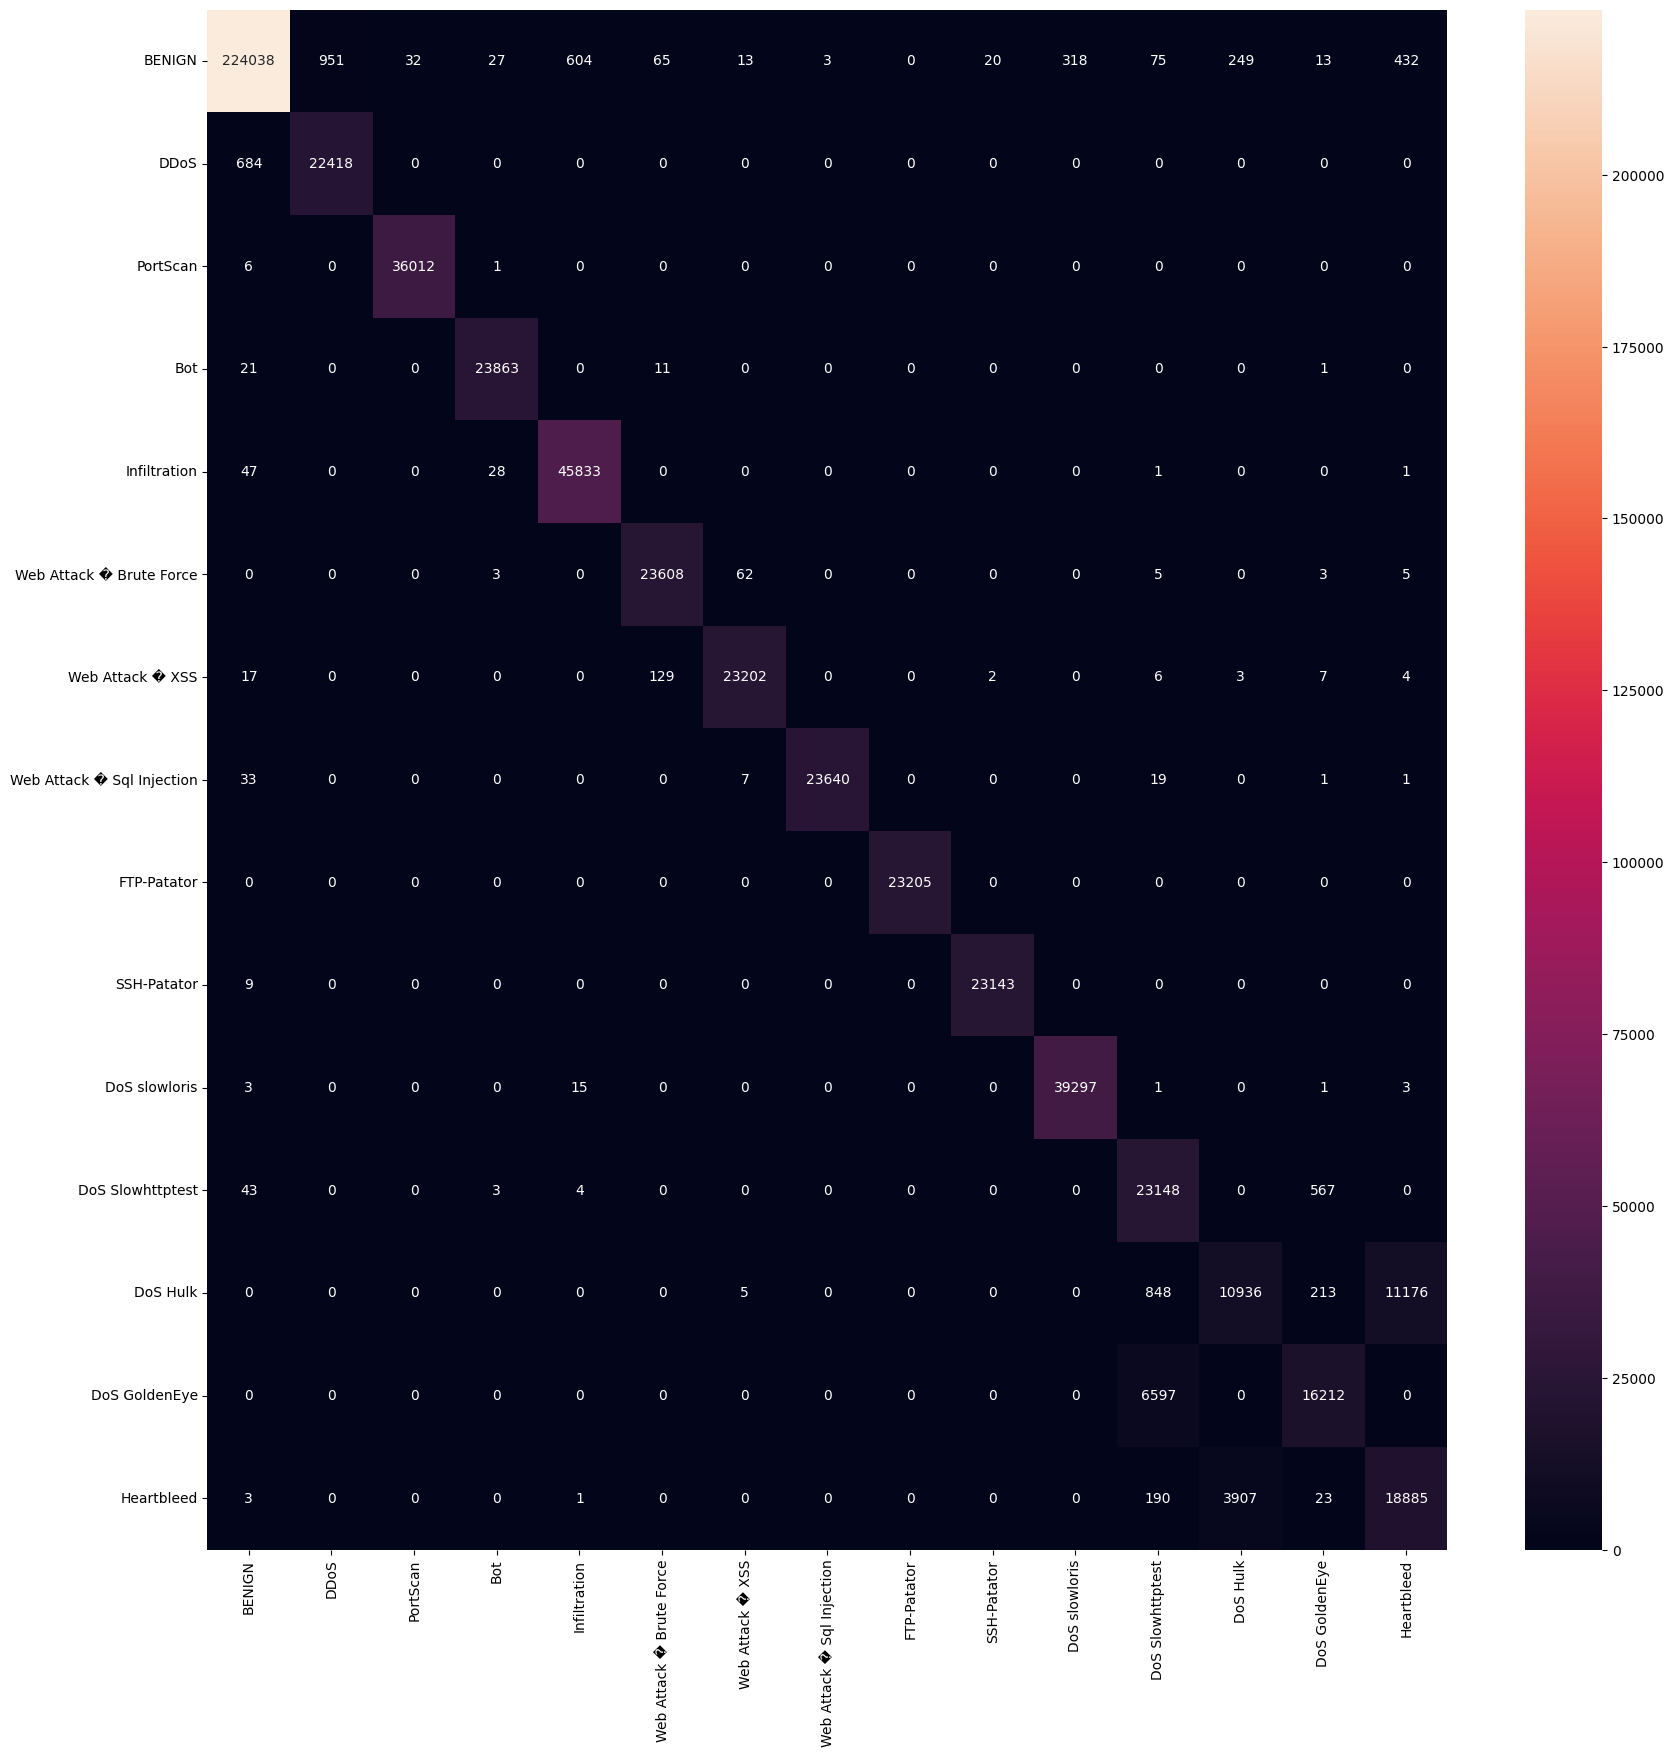

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(_confusion_matrix, annot=True, fmt='d', xticklabels=_labels, yticklabels=_labels)

In [ ]:
del _logits_on_test_data
del _predictions_on_test_data
del _labels_on_test_data

### Train for Binary Classification

In [89]:
def prepare_binary_classification_taining_labels(__original_labels, __positive_label):
    _np_labels = __original_labels.argmax(axis=1)
    _arr0 = [np.array([1, 0]) if dataset._label_index_to_name[_i] == __positive_label else np.array([0, 1]) for _i in _np_labels]
    return np.stack(np.array(_arr0)).astype('float64')

In [101]:
# dataset.load_preprocessed_smote_dataset()
# dataset.load_preprocessed_dataset()
dataset.load_caee_generated_dataset()

True

In [102]:
dataset.prepare_train_test_data(0.3)

In [103]:
dataset._train_data.head()

Destination Port   Flow Duration   Total Fwd Packets  \
3937038          -5.362968    1.040478e+00           -9.978268   
1227141           0.808606    5.666666e-07            0.000000   
5059626          -1.180524   -9.120598e+00          -17.750510   
4982206          -2.126934   -9.991655e+00          -15.761122   
5710895          -7.847664   -2.954042e+00           -9.538263   

          Total Backward Packets  Total Length of Fwd Packets  \
3937038               -15.068897                -1.074475e+01   
1227141                 0.000003                 4.651163e-07   
5059626               -13.665924                -1.723203e+01   
4982206               -12.739428                -1.529734e+01   
5710895                -9.339809                -8.947094e+00   

          Total Length of Bwd Packets   Fwd Packet Length Max  \
3937038                 -1.638703e+01               -7.191121   
1227141                  9.153974e-09                0.000242   
5059626                 -1.870270e+01              -10.409863   
4982206                 -1.722973e+01              -10.385815   
5710895                 -1.277769e+01               -4.098101   

          Fwd Packet Length Min   Fwd Packet Length Mean  \
3937038              -28.185660                -6.222592   
1227141                0.002581                 0.001010   
5059626               -8.412037                -8.651815   
4982206               -8.888336                -9.668218   
5710895              -13.588986                -4.213454   

          Fwd Packet Length Std  Bwd Packet Length Max  \
3937038               -6.508642              -9.430586   
1227141                0.000000               0.000307   
5059626              -12.151737              -8.763898   
4982206              -10.587147              -6.531027   
5710895               -4.030631              -2.552526   

          Bwd Packet Length Min   Bwd Packet Length Mean  \
3937038              -14.724203                -9.233018   
1227141                0.002072                 0.001034   
5059626               -6.743541                -7.445540   
4982206               -5.830784                -5.749112   
5710895              -11.977922                -3.086413   

          Bwd Packet Length Std  Flow Bytes/s   Flow Packets/s  \
3937038               -9.471522     -1.984042        -0.583559   
1227141                0.000000      0.112015         0.339394   
5059626               -9.806382     -2.078824        -0.689355   
4982206               -7.668529     -2.078361        -0.728863   
5710895               -2.756659     -1.975641        -0.663297   

          Flow IAT Mean   Flow IAT Std   Flow IAT Max   Flow IAT Min  \
3937038   -2.051207e+00      -1.469892  -5.378907e-01  -6.229813e+00   
1227141    5.666666e-07       0.000000   5.666666e-07   5.749999e-07   
5059626   -1.142995e+01     -10.433725  -9.756926e+00  -1.732879e+01   
4982206   -1.190017e+01     -10.724698  -1.025005e+01  -1.348883e+01   
5710895   -6.149348e+00      -4.897199  -4.102650e+00  -1.582023e+01   

         Fwd IAT Total   Fwd IAT Mean   Fwd IAT Std   Fwd IAT Max  \
3937038       1.067479      -2.140575     -1.355899     -0.483953   
1227141       0.000000       0.000000      0.000000      0.000000   
5059626      -9.914655     -11.702377    -12.059734    -10.658103   
4982206     -10.022191     -11.071307     -9.817917    -10.125256   
5710895      -3.179573      -5.791480     -4.725935     -4.116854   

          Fwd IAT Min  Bwd IAT Total   Bwd IAT Mean   Bwd IAT Std  \
3937038 -7.312961e+00      -2.778001      -3.519967     -4.156334   
1227141  9.999999e-08       0.000000       0.000000      0.000000   
5059626 -1.300427e+01      -7.860302      -9.396398    -10.332673   
4982206 -1.245199e+01     -11.699187     -12.395610    -11.850168   
5710895 -1.349839e+01      -3.124339      -5.800844     -4.589819   

          Bwd IAT Max   Bwd IAT Min  Fwd PSH Flags   Fwd URG Flags  \
3937038     -3.420957     -4.2

In [104]:
dataset._train_labels.value_counts()

BENIGN  Bot  DDoS  DoS GoldenEye  DoS Hulk  DoS Slowhttptest  DoS slowloris  FTP-Patator  Heartbleed  Infiltration  PortScan  SSH-Patator  Web Attack � Brute Force  Web Attack � Sql Injection  Web Attack � XSS
1.0     0.0  0.0   0.0            0.0       0.0               0.0            0.0          0.0         0.0           0.0       0.0          0.0                       0.0                         0.0                 1590626
0.0     0.0  0.0   0.0            1.0       0.0               0.0            0.0          0.0         0.0           0.0       0.0          0.0                       0.0                         0.0                  322154
                                  0.0       0.0               0.0            0.0          0.0         0.0           1.0       0.0          0.0                       0.0                         0.0                  271833
             1.0   0.0            0.0       0.0               0.0            0.0          0.0         0.0           0.0       0

In [105]:
_labels = dataset.get_labels()
_class_based_accuracies = []
for _i in range(len(_labels)):
    print(f"Label {_i} ({dataset._label_index_to_name[_i]})")
    _tf_model_v1 = create_tf_model_v0(70, 2)
    print("Training...")
    _train_y = prepare_binary_classification_taining_labels(dataset._train_labels.to_numpy(), dataset._label_index_to_name[_i])
    _tf_model_v1.fit(dataset._train_data.to_numpy(), _train_y, batch_size=1024, epochs=2)
    print("Evaluating...")
    _test_y = prepare_binary_classification_taining_labels(dataset._test_labels.to_numpy(), dataset._label_index_to_name[_i])
    # _loss_value, _acc_value = _tf_model_v1.evaluate(dataset._test_data.to_numpy(), _test_y)
    _predictions_on_test_data = _tf_model_v1.predict(dataset._test_data.to_numpy())
    _total_cases = dataset._test_data.shape[0]
    _actual_positive_cases = np.count_nonzero(_test_y.argmax(axis=1) == 0)
    _correct_predictions = np.count_nonzero(_predictions_on_test_data.argmax(axis=1) == _test_y.argmax(axis=1))
    _true_positive_cases = np.count_nonzero((_predictions_on_test_data.argmax(axis=1) == 0) & (_test_y.argmax(axis=1) == 0))
    _false_positive_cases = np.count_nonzero((_predictions_on_test_data.argmax(axis=1) == 0) & (_test_y.argmax(axis=1) == 1))
    _false_negative_cases = np.count_nonzero((_predictions_on_test_data.argmax(axis=1) == 1) & (_test_y.argmax(axis=1) == 0))
    _true_negative_cases = np.count_nonzero((_predictions_on_test_data.argmax(axis=1) == 1) & (_test_y.argmax(axis=1) == 1))
    _accuracy_value = _correct_predictions / _total_cases
    _precision_value = _true_positive_cases / (_true_positive_cases + _false_positive_cases + 0.00000000001)
    _recall_value = _true_positive_cases / (_true_positive_cases + _false_negative_cases + 0.00000000001)
    _f1_score_value = 2 * ( (_precision_value * _recall_value) / (_precision_value + _recall_value + 0.0000000001) )
    _class_based_accuracies.append([dataset._label_index_to_name[_i], _accuracy_value, _precision_value, _recall_value, _f1_score_value, _correct_predictions, _total_cases])
    print(f"Accuracy: {_accuracy_value}, Precision: {_precision_value}, Recall: {_recall_value}, F1 Score: {_f1_score_value}, Correct Predictions: {_correct_predictions}, Total Cases: {_total_cases}")
    print("--------------------------------------------------")
_class_based_accuracies = pd.DataFrame(_class_based_accuracies, columns=["Label", "Accuracy", "Precision", "Recall", "F1 Score", "Correct Predictions", "Total Cases"])

Label 0 (BENIGN)
Training...
Epoch 1/2
4136/4136 [==============================] - 78s 19ms/step - loss: 0.0383 - accuracy: 0.9835
Epoch 2/2
4136/4136 [==============================] - 82s 20ms/step - loss: 0.0228 - accuracy: 0.9896
Evaluating...
56716/56716 [==============================] - 70s 1ms/step
Accuracy: 0.9908666339005688, Precision: 0.9971047297398449, Recall: 0.9784896003196737, F1 Score: 0.9877094640185752, Correct Predictions: 1798308, Total Cases: 1814884
--------------------------------------------------
Label 1 (Bot)
Training...
Epoch 1/2
4136/4136 [==============================] - 72s 17ms/step - loss: 0.0051 - accuracy: 0.9991
Epoch 2/2
4136/4136 [==============================] - 63s 15ms/step - loss: 0.0016 - accuracy: 0.9997
Evaluating...
56716/56716 [==============================] - 52s 921us/step
Accuracy: 0.9997939262233839, Precision: 0.9998992356302809, Recall: 0.9947443039424879, F1 Score: 0.9973151085660606, Correct Predictions: 1814510, Total Cases: 

In [107]:
_class_based_accuracies

Label  Accuracy  Precision    Recall  F1 Score  \
0                       BENIGN  0.990867   0.997105  0.978490  0.987709   
1                          Bot  0.999794   0.999899  0.994744  0.997315   
2                         DDoS  0.999633   0.998842  0.994958  0.996896   
3                DoS GoldenEye  0.999856   0.999321  0.997055  0.998187   
4                     DoS Hulk  0.997813   0.972587  0.999421  0.985821   
5             DoS Slowhttptest  0.999772   0.997310  0.996844  0.997077   
6                DoS slowloris  0.999824   0.998954  0.996530  0.997740   
7                  FTP-Patator  0.999967   0.999327  0.999846  0.999586   
8                   Heartbleed  0.999999   1.000000  0.999971  0.999985   
9                 Infiltration  0.999969   1.000000  0.999177  0.999588   
10                    PortScan  0.994464   0.924221  0.995841  0.958695   
11                 SSH-Patator  0.999561   0.998311  0.990359  0.994319   
12    Web Attack � Brute Force  0.999760   0.999986  0.993754  0.996860   
13  Web Attack � Sql Injection  0.999991   0.999913  0.999841  0.999877   
14            Web Attack � XSS  0.999885   0.999884  0.997112  0.998496   

    Correct Predictions  Total Cases  
0               1798308      1814884  
1               1814510      1814884  
2               1814218      1814884  
3               1814622      1814884  
4               1810914      1814884  
5               1814471      1814884  
6               1814564      1814884  
7               1814825      1814884  
8               1814882      1814884  
9               1814827      1814884  
10              1804836      1814884  
11              1814087      1814884  
12              1814448      1814884  
13              1814867      1814884  
14              1814676      1814884

In [108]:
# _class_based_accuracies.to_csv('class_based_accuracies.csv', index=False)
# _class_based_accuracies.to_csv('class_based_accuracies_smote.csv', index=False)
_class_based_accuracies.to_csv('class_based_accuracies_caaee.csv', index=False)

In [44]:
a = pd.read_csv('class_based_accuracies.csv')
_class_based_accuracies = pd.concat([_class_based_accuracies, a], axis=1)

In [45]:
_class_based_accuracies

Label  Accuracy  Precision    Recall  F1 Score  \
0                       BENIGN  0.984018   0.994401  0.962809  0.978350   
1                          Bot  0.995710   0.899746  0.999280  0.946905   
2                         DDoS  0.998923   0.983433  0.998662  0.990989   
3                DoS GoldenEye  0.999567   0.992249  0.996910  0.994574   
4                     DoS Hulk  0.997667   0.971988  0.998187  0.984913   
5             DoS Slowhttptest  0.999351   0.991535  0.991816  0.991675   
6                DoS slowloris  0.999264   0.992613  0.988493  0.990549   
7                  FTP-Patator  0.999778   0.997625  0.996728  0.997176   
8                   Heartbleed  1.000000   1.000000  1.000000  1.000000   
9                 Infiltration  0.999658   0.999373  0.991654  0.995499   
10                    PortScan  0.994438   0.922692  0.997344  0.958566   
11                 SSH-Patator  0.974006   0.599931  0.991012  0.747405   
12    Web Attack � Brute Force  0.971012   0.634989  0.576645  0.604412   
13  Web Attack � Sql Injection  0.983220   0.993475  0.562479  0.718285   
14            Web Attack � XSS  0.972541   0.627779  0.688760  0.656857   

    Correct Predictions  Total Cases                       Label  Accuracy  \
0               1785878      1814884                      BENIGN  0.980165   
1               1807098      1814884                         Bot  0.999574   
2               1812929      1814884                        DDoS  0.999129   
3               1814099      1814884               DoS GoldenEye  0.999789   
4               1810650      1814884                    DoS Hulk  0.992645   
5               1813706      1814884            DoS Slowhttptest  0.999685   
6               1813548      1814884               DoS slowloris  0.999783   
7               1814482      1814884                 FTP-Patator  0.999938   
8               1814884      1814884                  Heartbleed  0.999998   
9               1814264      1814884                Infiltration  0.999988   
10              1804790      1814884                    PortScan  0.988280   
11              1767707      1814884                 SSH-Patator  0.999577   
12              1762274      1814884    Web Attack � Brute Force  0.999511   
13              1784430      1814884  Web Attack � Sql Injection  0.999993   
14              1765049      1814884            Web Attack � XSS  0.999773   

    Precision    Recall  F1 Score  Correct Predictions  Total Cases  
0    0.994430  0.980785  0.987560               831536       848363  
1    0.985646  0.365248  0.532988               848002       848363  
2    0.999787  0.980917  0.990262               847624       848363  
3    0.976069  0.967120  0.971574               848184       848363  
4    0.997883  0.911848  0.952928               842123       848363  
5    0.882774  0.967431  0.923165               848096       848363  
6    0.917685  0.983495  0.949451               848179       848363  
7    0.998246  0.978934  0.988496               848310       848363  
8    1.000000  0.666667  0.800000               848361       848363  
9    0.000000  0.000000  0.000000               848353       848363  
10   0.828676  0.998599  0.905737               838420       848363  
11   0.936679  0.861065  0.897282               848004       848363  
12   0.954545  0.048276  0.091904               847948       848363  
13   0.000000  0.000000  0.000000               848357       848363  
14   0.000000  0.000000  0.000000               848170       848363